## Importing Libraries

In [1]:
from google.colab import files
from google.colab import auth
from googleapiclient.discovery import build  # To interact with Google APIs
from googleapiclient.errors import HttpError  # To handle API errors
import google.auth  # For retrieving credentials
import re

## Authenticate the user and set up Google Docs API

In [2]:
def authenticate_with_colab():
    """
    Authenticates the user in the Colab environment using Google authentication.
    Initializes the Google Docs API service.
    Returns the Google Docs API service object.
    """
    auth.authenticate_user()  # Authenticate the Colab session
    creds, _ = google.auth.default()  # Get default credentials
    service = build('docs', 'v1', credentials=creds)  # Build the Google Docs API client
    return service

## Create a new Google Doc with the specified title

In [3]:
def create_google_doc(service, title):
    """
    Creates a new Google Doc with the given title.

    Args:
        service: Google Docs API service object.
        title: Title of the new Google Doc.

    Returns:
        The document ID of the newly created Google Doc or None if an error occurs.
    """
    try:
        # Create a new Google Doc
        doc = service.documents().create(body={"title": title}).execute()
        doc_id = doc.get('documentId')
        print(f"Created document with ID: {doc_id}")
        print(f"Document Link: https://docs.google.com/document/d/{doc_id}")
        return doc_id
    except HttpError as error:
        # Handle API errors
        print(f"An error occurred: {error}")
        return None
    except Exception as e:
        # Handle unexpected errors
        print(f"An unexpected error occurred: {e}")
        return None

## Apply a batch of updates to a Google Doc

In [4]:
def batch_update_google_doc(service, doc_id, requests):
    """
    Sends a batch of update requests to the specified Google Doc.

    Args:
        service: Google Docs API service object.
        doc_id: Document ID of the Google Doc to update.
        requests: List of update requests for formatting and content.

    Returns:
        The result of the batch update operation or None if an error occurs.
    """
    try:
        # Execute batch update
        result = service.documents().batchUpdate(documentId=doc_id, body={'requests': requests}).execute()
        return result
    except HttpError as error:
        # Handle API errors
        print(f"An error occurred: {error}")
        return None
    except Exception as e:
        # Handle unexpected errors
        print(f"An unexpected error occurred: {e}")
        return None


## Parse markdown and format the Google Doc

In [5]:
def parse_markdown(service, doc_id, md_text):
    current_index = 1
    requests = []
    lines = md_text.split('\n')
    footer_detected = False
    initial_whitespace_count = len(lines[0]) - len(lines[0].lstrip()) # Initial leading whitespaces in string



    for line in lines:
        stripped_line = line.strip()

        if stripped_line == '---':
            footer_detected = True
            # Add space before footer
            requests.append({
                'insertText': {
                    'location': {'index': current_index},
                    'text': '\n'
                }
            })
            current_index += 1
            continue

        # Footer Styling
        if footer_detected:
            if stripped_line:
                requests.append({
                    'insertText': {
                        'location': {'index': current_index},
                        'text': stripped_line + '\n'
                    }
                })
                requests.append({
                    'updateTextStyle': {
                        'range': {'startIndex': current_index, 'endIndex': current_index + len(stripped_line)},
                        'textStyle': {
                            'italic': True,
                            'foregroundColor': {
                                'color': {
                                    'rgbColor': {
                                        'red': 0.4, 'green': 0.4, 'blue': 0.4  # Light grey
                                    }
                                }
                            }
                        },
                        'fields': 'italic,foregroundColor'
                    }
                })

                current_index += len(stripped_line) + 1
            continue

        # Handle headings
        heading_match = re.match(r'^(#+)\s+(.*)', stripped_line)
        if heading_match:
            heading_level = len(heading_match.group(1))
            heading_text = heading_match.group(2)
            requests.append({
                'insertText': {
                    'location': {'index': current_index},
                    'text': heading_text + '\n'
                }
            })
            requests.append({
                'updateParagraphStyle': {
                    'range': {'startIndex': current_index, 'endIndex': current_index + len(heading_text)},
                    'paragraphStyle': {'namedStyleType': f'HEADING_{heading_level}'},
                    'fields': 'namedStyleType'
                }
            })
            current_index += len(heading_text) + 1

        # Handle checkboxes
        elif stripped_line.startswith('- [ ]'):
            checkbox_text = stripped_line[5:]
            requests.append({
                'insertText': {
                    'location': {'index': current_index},
                    'text': checkbox_text + '\n'
                }
            })
            requests.append({
                'createParagraphBullets': {
                    'range': {'startIndex': current_index, 'endIndex': current_index + len(checkbox_text)},
                    'bulletPreset': 'BULLET_CHECKBOX'
                }
            })
            current_index += len(checkbox_text) + 1

        # Handle bullet points with hierarchy
        elif stripped_line.startswith('*') or stripped_line.startswith('- '):
          normalized_line = line[initial_whitespace_count:] if line.startswith(' ' * initial_whitespace_count) else line
          indent_level = (len(line) - len(line.lstrip())) // 2
          bullet_text = stripped_line[1:].strip()
          bullet_level = indent_level - 4

          # Adjust styles and indentation for bullet points
          if bullet_level == 0:
              bullet_preset = 'BULLET_DISC_CIRCLE_SQUARE'
          elif bullet_level == 1:
              bullet_preset = 'BULLET_ARROW_DIAMOND_DISC'
          elif bullet_level == 2:
              bullet_preset = 'BULLET_DISC_CIRCLE_SQUARE'
          elif bullet_level >= 3:
              bullet_preset = 'BULLET_DISC_CIRCLE_SQUARE'

          requests.extend([
              {
                  'insertText': {
                      'location': {
                          'index': current_index
                      },
                      'text': bullet_text + '\n'
                  }
              },
              {
                  'createParagraphBullets': {
                      'range': {
                          'startIndex': current_index,
                          'endIndex': current_index + len(bullet_text) + 1
                      },
                      'bulletPreset': bullet_preset
                  }
              },
              {
                  'updateParagraphStyle': {
                      'range': {
                          'startIndex': current_index,
                          'endIndex': current_index + len(bullet_text) + 1
                      },
                      'paragraphStyle': {
                          'indentStart': {
                              'magnitude': (indent_level-2) * 18,
                              'unit': 'PT'
                          },
                          'indentFirstLine': {
                              'magnitude': ((indent_level-2) * 18) - 18,
                              'unit': 'PT'
                          }
                      },
                      'fields': 'indentStart,indentFirstLine'
                  }
              }
          ])
          current_index += len(bullet_text) + 1

        # Handle plain text
        else:
            if stripped_line:
                requests.append({
                    'insertText': {
                        'location': {'index': current_index},
                        'text': stripped_line + '\n'
                    }
                })
                current_index += len(stripped_line) + 1

        # Handle assignee mentions
        if re.search(r'(@\w+)', stripped_line):
          # First `re.search` result is reused
          match = re.search(r'(@\w+)', stripped_line)

          # Insert the line
          requests.append({
              'insertText': {
                  'location': {'index': current_index},
                  'text': stripped_line + '\n'
              }
          })

          # Apply mention styling using the match result
          if match:
              mention_start = current_index + match.start(1) - (len(stripped_line) + 1)
              mention_end = current_index + match.end(1) - (len(stripped_line) + 1)
              requests[-1] = ({
                  'updateTextStyle': {
                      'range': {
                          'startIndex': mention_start,
                          'endIndex': mention_end
                      },
                      'textStyle': {
                          'italic': True,
                          'foregroundColor': {
                              'color': {
                                  'rgbColor': {
                                      'red': 0.4, 'green': 0.4, 'blue': 0.4  # Light grey
                                  }
                              }
                          }
                      },
                      'fields': 'italic,foregroundColor'
                  }
              })

    # Send all requests in one batch
    if requests:
        batch_update_google_doc(service, doc_id, requests)

## Main function to run the script

In [7]:
def main():
    """
    Main function to authenticate, create a Google Doc, and format it using markdown.
    """
    service = authenticate_with_colab()  # Authenticate with Google Docs API
    doc_title = "Product Team Sync - Enhanced Markdown Parser"
    doc_id = create_google_doc(service, doc_title)  # Create a new Google Doc

    if doc_id:
        markdown_text = markdown_text = """
        # Product Team Sync - May 15, 2023

        ## Attendees
        - Sarah Chen (Product Lead)
        - Mike Johnson (Engineering)
        - Anna Smith (Design)
        - David Park (QA)

        ## Agenda

        ### 1. Sprint Review
        * Completed Features
          * User authentication flow
          * Dashboard redesign
          * Performance optimization
            * Reduced load time by 40%
            * Implemented caching solution
        * Pending Items
          * Mobile responsive fixes
          * Beta testing feedback integration

        ### 2. Current Challenges
        * Resource constraints in QA team
        * Third-party API integration delays
        * User feedback on new UI
          * Navigation confusion
          * Color contrast issues

        ### 3. Next Sprint Planning
        * Priority Features
          * Payment gateway integration
          * User profile enhancement
          * Analytics dashboard
        * Technical Debt
          * Code refactoring
          * Documentation updates

        ## Action Items
        - [ ] @sarah: Finalize Q3 roadmap by Friday
        - [ ] @mike: Schedule technical review for payment integration
        - [ ] @anna: Share updated design system documentation
        - [ ] @david: Prepare QA resource allocation proposal

        ## Next Steps
        * Schedule individual team reviews
        * Update sprint board
        * Share meeting summary with stakeholders

        ## Notes
        * Next sync scheduled for May 22, 2023
        * Platform demo for stakeholders on May 25
        * Remember to update JIRA tickets

        ---
        Meeting recorded by: Sarah Chen
        Duration: 45 minutes
        """
        parse_markdown(service, doc_id, markdown_text)  # Parse and format the Google Doc
        print(f"Success! Created Doc ID: {doc_id}")
    else:
        print("Failed to create the document.")

# Run the script
if __name__ == "__main__":
    main()

Created document with ID: 19q4GwU5_cVfZehy8tkDbaYt6w_n62458Mf5a-orxgJU
Document Link: https://docs.google.com/document/d/19q4GwU5_cVfZehy8tkDbaYt6w_n62458Mf5a-orxgJU
Success! Created Doc ID: 19q4GwU5_cVfZehy8tkDbaYt6w_n62458Mf5a-orxgJU


# Output:

Your Goole Docs output should look something like this:


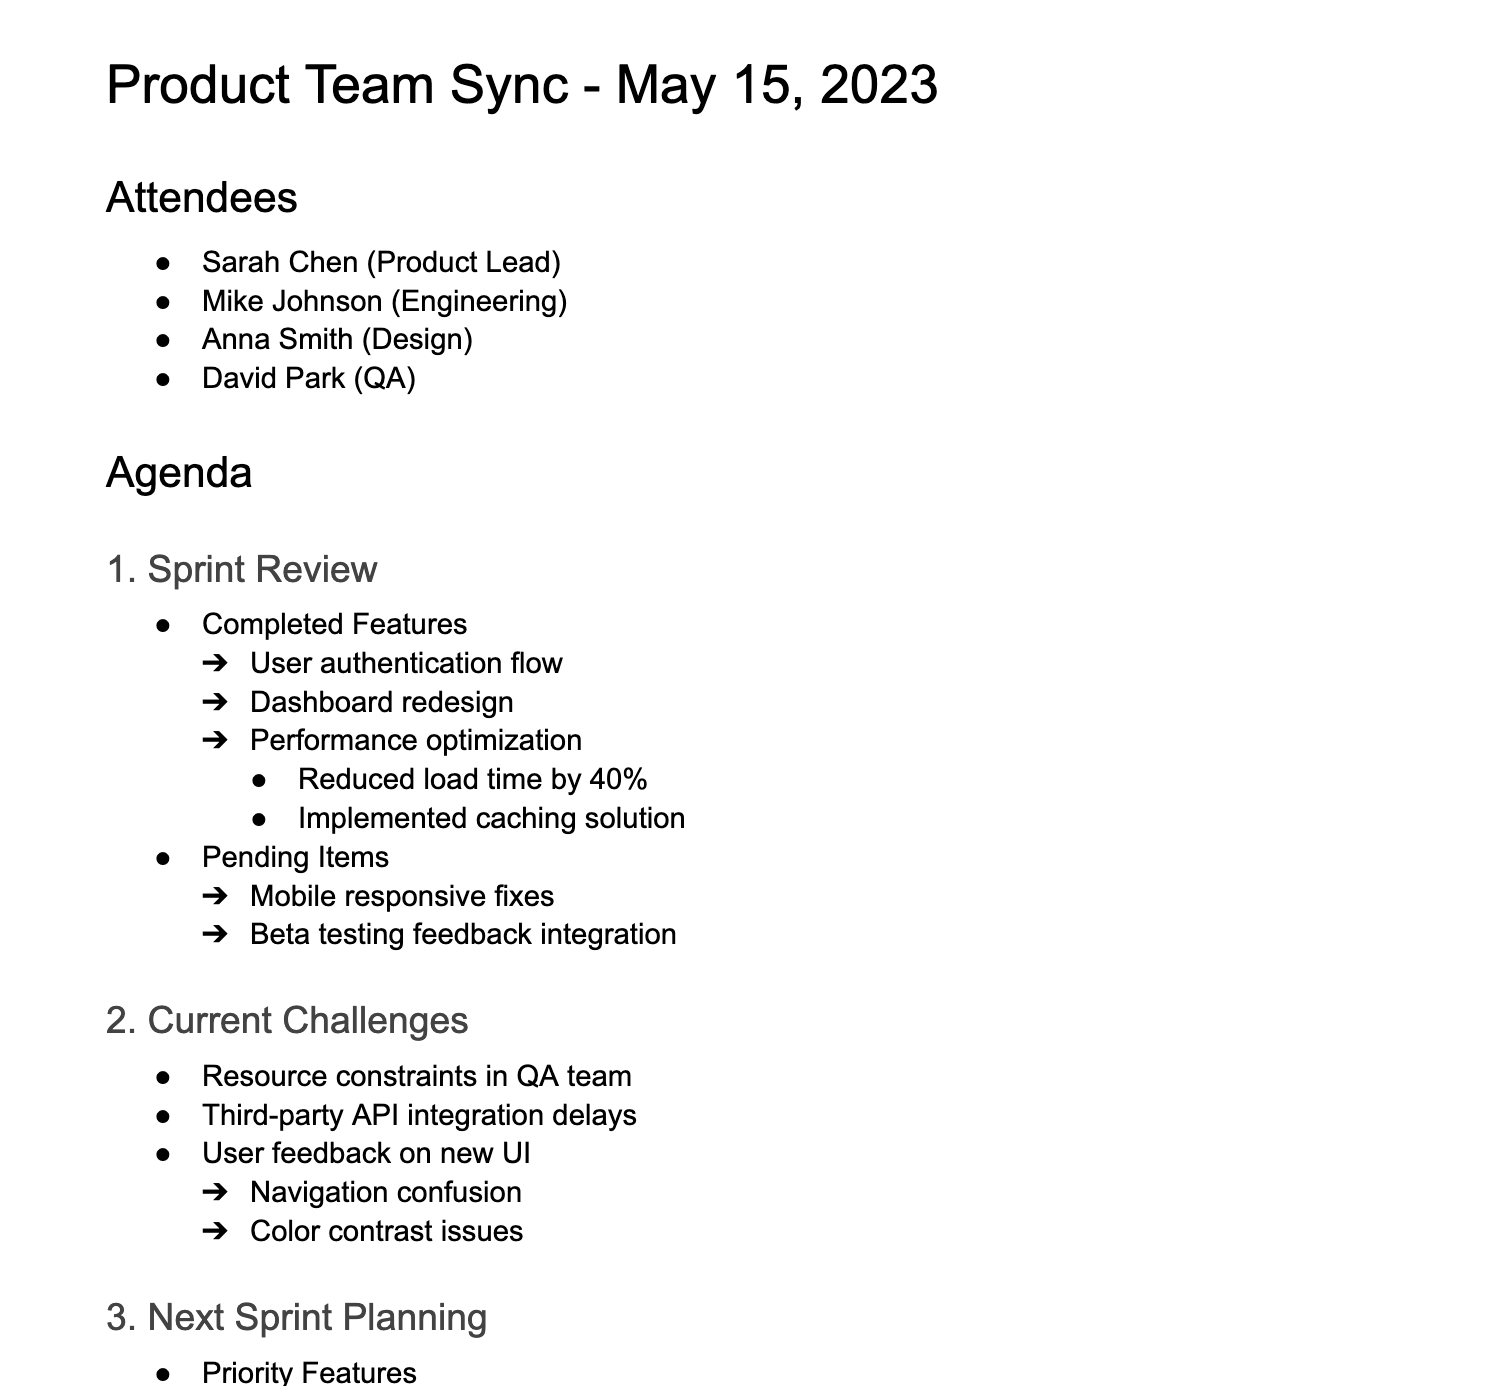

# Thank you!